# Setup and Imports

In [205]:

#!/home/ghassanmakhoul/miniconda3/envs/tornado/bin/python
import torch
import torch.nn as nn
import numpy as np
from sklearn.decomposition import PCA
import math
import ToroidalSOM
import pdb
import pickle
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from SOMInterface import *

In [4]:
#Basic Loading 
#pdb.set_trace()
codename = "sheldrake"
print(f"Loading Toroidal SOM pretrained weights from FILE: {codename}")
bse, som,bsp = get_bse(codename)




Loading Toroidal SOM pretrained weights from FILE: sheldrake


Downloading: "https://github.com/grahamwjohnson/seeg_tornados_2/zipball/main" to ./.torch_hub_cache/main.zip


Initializing weights randomly...


In [14]:
#Set up SOM and confirm loaded
som.reset_device(0)
som.batch_size = 10
print("RESET Device\n\n")
print(f"Toroidal SOM model loaded from {codename}: \n{som}")

## pass random input to just verify that we can infer
latent_means_input = torch.rand((100,1024))

som_row_col = get_som_rowcol(latent_means_input, som)
print(f"Random embedding: first 5 rows,cols of interence: \n{som_row_col[0:5,:]}")


RESET Device


Toroidal SOM model loaded from sheldrake: 
ToroidalSOM()
Random embedding: first 5 rows,cols of interence: 
[[79 53]
 [79 53]
 [79 53]
 [79 53]
 [79 53]]


In [ ]:
# Load BSE Embeddings and 

with open("../data/Train45_allDataGathered_subsampleFileFactor1_64secWindow_32secStride.pkl", 'rb') as f:
    bse_data_dict = pickle.load(f)

# NOTE: ww in the keys means that it has already been windowed and weighted by the MOG preds already
# NOTE: windowing is based on the file name
# NOTE: for ww_means_allfiles (N_lilpickles, n_time-points averaged via windowing,1024 is latent dim space )
# NOTE: each lil pickle's start datetime as a datetime object
# NOTE: Can use all_times_.csv to ascertain pre-ictal-ness
# NOTE: Can use time stamps from sleep_staging for sleep periods

# SOM Inference on all data in batches
# all_means = bse_data_dict['ww_means_allfiles'] # reshaped to shape_dim 0 x shape_dim 1


#NOTE: need to get the best matching unit out, that's a row and a column

#NOTE: can plot with squares but lines will be jagged
# Pre-ictal visualization and ictal

# log transformed the hit map, 
# NOTE: Validation data clumps more than the training data, could mean that 
# validation is less similar to the gamut of BMUs on the toroid.
# # can check hitmap for validation to see that most "hit" areas are not just pre-ictal
# NOTE: consider coloring seizures at the end of all this

# NOTE: BSE trained with SPES, but SOM not trained with any SPES data

#NOTE: Goals
# 1. Sleep
# 2. Pre-Ictal
#       a. 4 hour pre-ictal
#       b. down to 1 hour pre-ictal
# 3. Seizures
# 4


# Building the SOM Visualization
Any good SOM needs a U-Matrix and a Component Plane, for street cred. Let's start out by builidng the U-Matrix. Current Understanding of the U-Matrix is as follows: This matrix represents the distance between "neurons" in the self organizing map. The idea is that for any given neuron i, it's U-matrix value will be calculated by evaluatin
The **U-matrix value** is calculated by evaluating the sum of distances between a neuron \( N_i \) and each of its \( K \) neighbors:

$$U(i) = \sum_{k=1}^{K} d(N_i, N_k)$$
where $$d(u, v)$$ is the **Euclidean distance** between the weight vectors of neurons \( u \) and \( v \), defined as:


$$d(u, v) = \left\| \mathbf{w}_u - \mathbf{w}_v \right\|_2 = \sqrt{\sum_{j=1}^{D} \left( w_{u,j} - w_{v,j} \right)^2}$$

Here, $\mathbf{w}_u$ and $\mathbf{w}_v$ are the weight vectors of neurons $u$ and $v$, respectively, and $D$ is the dimensionality of the input space.  
The neurons $u$ and $v$ are indexed according to the **hexagonal coordinate system**.

In [172]:

def euc_dist(a: np.ndarray, b: np.ndarray):
    """Calculates euclidean distance between vectors a,b
    also equipped for euclidean distance between vector a and set of vectors.
    A has to always be a single vector while b can be a set of vectors"""
    assert len(a.shape) ==1 or a.shape[0] <2 or a.shape[1] <2, "Make sure a is not the sef of vecs. Also programmed to handle distance b/w 2 sets of vectors!"
    inner =  np.dot((a-b), (a-b).T)
    if b.shape[0]>1 or b.shape[1] > 1:
        return np.sqrt(inner.diagonal())
    return np.sqrt(inner)

def get_neighbors(ref_hex: tuple, hex_coords: np.ndarray ,radius: float):
    """Given a reference hexagon specified by a tuple of indices i,j
    uses the hexagon's corresponding coordinate value, by slicing 
    into hex_coods[i,j,:] RETURNS a list of indices (row,col) for the neighbors 
    of the REF_HEX within a given RADIUS of the REF_HEX's coordinates"""
    ref_x, ref_y = hex_coords[ref_hex[0],ref_hex[1],:]
    #make ref the new origin
    shifted_hex = np.zeros(np.shape(hex_coords))
    shifted_hex[:,:,0] =  hex_coords[:,:,0] - ref_x
    shifted_hex[:,:,1] = hex_coords[:,:,1] - ref_y
    in_circle_mask = np.logical_and(np.abs(shifted_hex[:,:,0]) < radius, np.abs(shifted_hex[:,:,1]) < radius)
    r,c =  np.where(in_circle_mask)
    return r,c


def get_bmu(vec: np.ndarray, neurons: np.ndarray, dist_fn) -> tuple:
    """Returns an index (i,j) Given a vector VEC (1x D) the get_bmu function returns
    the neuron from NEURONS (a NxNxD matrix) which is the minimal 
    distance as specified by any DIST_FN"""
    n, _, d = neurons.shape
    neurons_flat = np.reshape(neurons, (n**2, d))
    dists = dist_fn(vec, neurons_flat)
    n_min = np.argmin(dists)
    return np.unravel_index(n_min, (n,n))



In [ ]:
##loading and getting set up
weights = som.get_weights()
hex_coords = som.get_hex_coords()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device to use: {device}")

device(type='cuda')

In [177]:
rand = np.random.random_integers(-1,1,(1,1024))
torch_vec = torch.from_numpy(rand).to(device)

print(f"Ghassan Implementatino of BMU: {get_bmu(rand, weights,euc_dist)}")
print(f"Graham Implementatino of BMU: { som.find_bmu(torch_vec)}")

/tmp/ipykernel_345241/1835790818.py:1: DeprecationWarning: This function is deprecated. Please call randint(-1, 1 + 1) instead
  rand = np.random.random_integers(-1,1,(1,1024))


Ghassan Implementatino of BMU: (np.int64(79), np.int64(53))
Graham Implementatino of BMU: (tensor([79], device='cuda:0'), tensor([53], device='cuda:0'))


Now that we can ask for our neighbors we can generate the U-matrix. For every neuron, let's get its neighbors up to a radius of 2 and compute the euclidean distance between the index neuron and the neurons within its radius. Granted I am not implementing the toroidal u-matrix update yet. This may not look perfect. I expect some edge weirdness.

In [196]:
N = hex_coords.shape[0]
U_matrix = np.zeros((N,N))
component_plane = np.zeros((N,N))
radius = 2
for i in range(N):
    for j in range(N):
        neigh_x, neigh_y = get_neighbors((i,j),hex_coords, radius)
        neighbor_set = weights[neigh_x,neigh_y,:]
        v_ref = weights[i,j,:]
        U_matrix[i,j] = np.mean(euc_dist(v_ref, neighbor_set))
        component_plane[i,j] = weights[i,j,420]
        
        

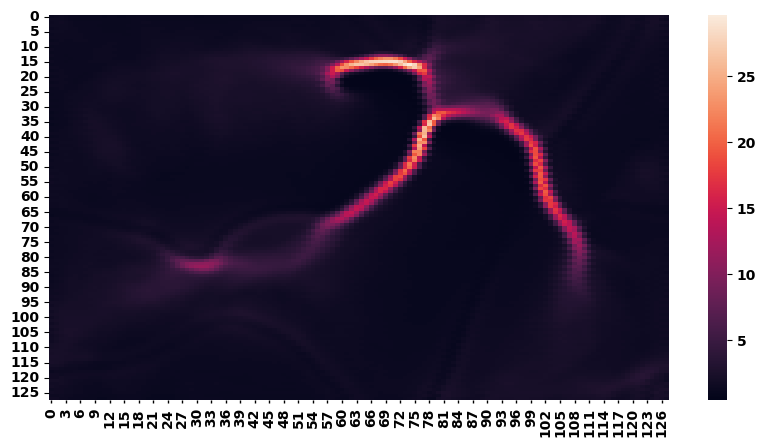

In [199]:
%matplotlib inline
with plt.style.context("./BIEN.mplstyle"):
    sns.heatmap(U_matrix)

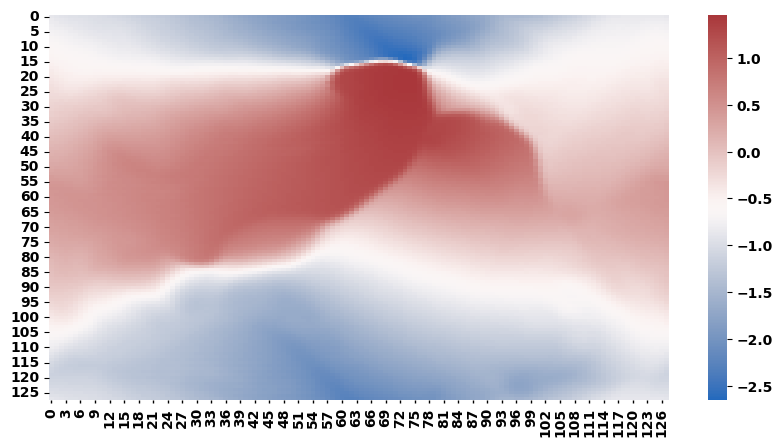

In [198]:
%matplotlib inline
with plt.style.context("./BIEN.mplstyle"):
    sns.heatmap(component_plane,  cmap='vlag')


## Validating Pre-Ictal
Now for the real meat and potata's. The pre-ictal plots have the following property: they highlight the BMUs that are most activated from the embeddings pulled from the time leading up to a seizure. Things to be mindful of:
1. The definition of pre-ictal is important, within 4 hours of a seizure, 2 hours, etc. 
    ii. Related point - timestamp management is crucial here. Need to rely on packages like timedelta
2. Indexing between embedding native shape and SOM expected shape all while preserving order. Remember that matlab is row-major indexed. That means that whenever we flatten an array, say a 10x10x2 array into a 100x2 array matlab will flatten row by row. Meeaning that the first ten 2D vectors will come from entris [0:10,0,:] then the second ten will come from [0:10,1,:] and so on. 
As far as index converstion: for a $10\times10\times2$ matrix, $N=10 $.  Given indices $i,j \mapsto f \coloneqq f = N*i +j$

$$\Rightarrow i = \left\lfloor \frac{f}{N} \right\rfloor,j=f\bmod{N} $$


In [201]:
# get all times csv
times_f = "/home/ghassanmakhoul/Documents/Tornadoes_v1/all_time_data_01092023_112957.csv"
times_df = pd.read_csv(times_f)

In [214]:
times_df

,Type,Pat ID,Event Number (Matches EMU Final Report),Date (MM:DD:YYYY),Onset String (HH:MM:SS),Offset String (HH:MM:SS),Seizure Type (FAS; FIAS; FBTC; Non-electrographic; Subclinical; Unknown),FileIndex,onset_datetime,offset_datetime,onset_datetime_buffer,offset_datetime_buffer,FileName,Unnamed: 13
0,File,Epat02,File1,09:14:2017,13:05:11,17:05:11,NaN,0,2017-09-14 13:05:11,2017-09-14 17:05:11,2017-09-14 13:06:11,2017-09-14 17:04:11,Epat02_09142017_13051100.EDF,NaN
1,File,Epat02,File2,09:14:2017,17:05:22,21:05:22,NaN,1,2017-09-14 17:05:22,2017-09-14 21:05:22,2017-09-14 17:06:22,2017-09-14 21:04:22,Epat02_09142017_17052200.EDF,NaN
2,File,Epat02,File3,09:14:2017,21:05:34,01:05:34,NaN,2,2017-09-14 21:05:34,2017-09-15 01:05:34,2017-09-14 21:06:34,2017-09-15 01:04:34,Epat02_09142017_21053400.EDF,NaN
3,File,Epat02,File4,09:15:2017,01:05:45,05:05:45,NaN,3,2017-09-15 01:05:45,2017-09-15 05:05:45,2017-09-15 01:06:45,2017-09-15 05:04:45,Epat02_09152017_01054500.EDF,NaN
4,File,Epat02,File5,09:15:2017,05:05:56,09:05:56,NaN,4,2017-09-15 05:05:56,2017-09-15 09:05:56,2017-09-15 05:06:56,2017-09-15 09:04:56,Epat02_09152017_05055600.EDF,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4434,Seizure,Spat114,5b,02:19:2025,10:34:17,10:35:53,FAS,0,2025-02-19 10:34:17.0000,2025-02-19 10:35:53.0000,NaN,NaN,NaN,NaN
4435,Seizure,Spat114,6b,02:20:2025,21:39:38,21:40:47,Focal unknown awareness,0,2025-02-20 21:39:38.0000,2025-02-20 21:40:47.0000,NaN,NaN,NaN,NaN
4436,Seizure,Spat114,7b,02:21:2025,00:11:40,00:12:48,Focal unknown awareness,0,2025-02-21 00:11:40.0000,2025-02-21 00:12:48.0000,NaN,NaN,NaN,NaN
4437,Seizure,Spat114,8,02:22:2025,19:10:53,19:13:00,FBTC,0,2025-02-22 19:10:53.0000,2025-02-22 19:13:00.0000,NaN,NaN,NaN,NaN


In [ ]:
pd.to_datetime(times_df['Onset String (HH:MM:SS)'])
# FF me this is gonna take a sec

/tmp/ipykernel_345241/3814093462.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(times_df['Onset String (HH:MM:SS)'])


DateParseError: Unknown datetime string format, unable to parse: Unknown, at position 1266